# Setup

In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU') 

2.12.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16283741968400978968
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12271657398928838596
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4472777568217732027
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 32
EPOCHS = 25
IMAGE_SIZE = 224
IMAGES_DIR = "../input/car-logos/Car_Brand_Logos"

In [4]:
from tensorflow import keras

# Grab training and testing data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{IMAGES_DIR}/Train',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{IMAGES_DIR}/Test',
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

NUM_CLASSES = len(train_ds.class_names)
train_ds.class_names

Found 2788 files belonging to 24 classes.
Found 604 files belonging to 24 classes.


['audi',
 'byd',
 'cadillac',
 'chevrolet',
 'citroën',
 'ferrari',
 'ford',
 'honda',
 'hyundai',
 'jeep',
 'lamborghini',
 'lexus',
 'mazda',
 'mercedes',
 'mini',
 'opel',
 'porsche',
 'skoda',
 'smart',
 'subaru',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo']

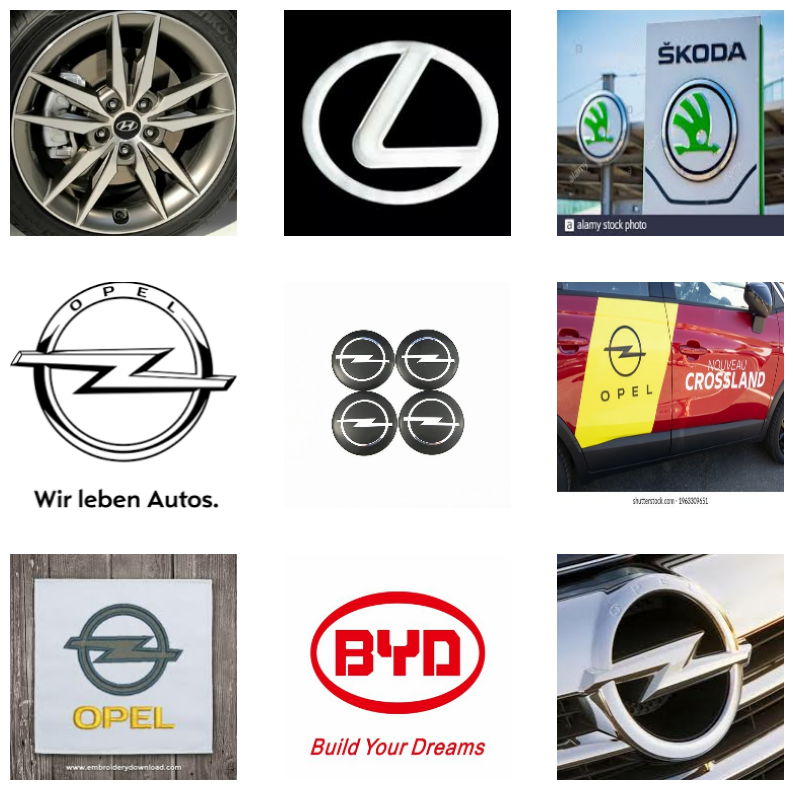

In [9]:
import matplotlib.pyplot as plt

# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Note to myself: Tool to find most optimal hyperparameters with custom model
# source - https://github.com/keras-team/keras-tuner

# Augment/Generate Data

In [15]:
from tensorflow.keras import layers

img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomBrightness(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

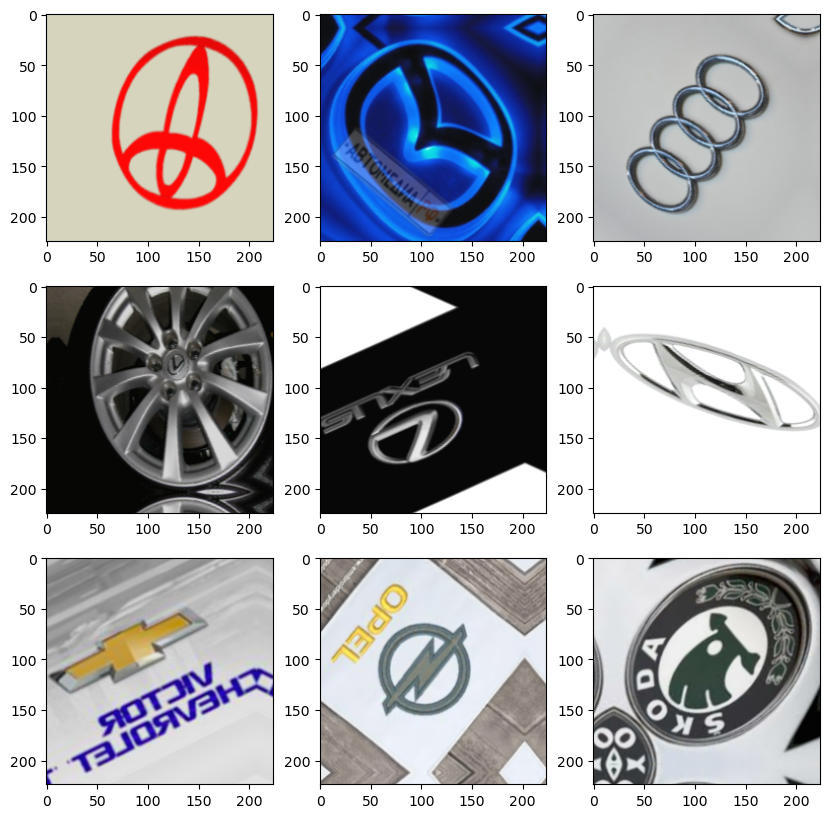

In [10]:
# Test the augmentation on some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = img_augmentation(images[i])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))

In [12]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import models

# Using EfficientNet + Transfer Learning
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = img_augmentation(inputs)
base_model = EfficientNetV2B0(include_top=False, input_tensor=x, weights="imagenet")
base_model.trainable = False # Freeze the pretrained weights

# Attach top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))
model.add(layers.Dense(NUM_CLASSES, activation="softmax", name="pred"))

optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 pred (Dense)                (None, 24)                30744     
                                                                 
Total params: 5,950,056
Trainable params: 30,744
Non-trainable params: 5,919,312
_________________________________________________________________


# Train

In [13]:
# https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
# https://keras.io/api/callbacks/early_stopping/
from keras.callbacks import CSVLogger

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto'),
    CSVLogger('training.log', separator=',', append=False)
]

In [16]:
# Use GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/25
76/88 [========================>.....] - ETA: 1s - loss: 1.1943 - accuracy: 0.6406

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 187ms/step - loss: 1.1828 - accuracy: 0.6445 - val_loss: 1.5305 - val_accuracy: 0.5563
Epoch 2/25
76/88 [========================>.....] - ETA: 1s - loss: 1.0640 - accuracy: 0.6900

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 196ms/step - loss: 1.0506 - accuracy: 0.6944 - val_loss: 1.4248 - val_accuracy: 0.6026
Epoch 3/25
76/88 [========================>.....] - ETA: 1s - loss: 1.0039 - accuracy: 0.7105

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 187ms/step - loss: 0.9892 - accuracy: 0.7156 - val_loss: 1.3543 - val_accuracy: 0.6209
Epoch 4/25
76/88 [========================>.....] - ETA: 1s - loss: 0.9175 - accuracy: 0.7397

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 192ms/step - loss: 0.9119 - accuracy: 0.7418 - val_loss: 1.3077 - val_accuracy: 0.6325
Epoch 5/25
76/88 [========================>.....] - ETA: 1s - loss: 0.8801 - accuracy: 0.7442

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 191ms/step - loss: 0.8690 - accuracy: 0.7478 - val_loss: 1.2737 - val_accuracy: 0.6325
Epoch 6/25
76/88 [========================>.....] - ETA: 1s - loss: 0.8499 - accuracy: 0.7447

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 197ms/step - loss: 0.8394 - accuracy: 0.7493 - val_loss: 1.2386 - val_accuracy: 0.6507
Epoch 7/25
76/88 [========================>.....] - ETA: 1s - loss: 0.8067 - accuracy: 0.7615

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 191ms/step - loss: 0.7943 - accuracy: 0.7672 - val_loss: 1.2310 - val_accuracy: 0.6474
Epoch 8/25
76/88 [========================>.....] - ETA: 1s - loss: 0.7956 - accuracy: 0.7627

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 185ms/step - loss: 0.7859 - accuracy: 0.7665 - val_loss: 1.2040 - val_accuracy: 0.6589
Epoch 9/25
76/88 [========================>.....] - ETA: 1s - loss: 0.7743 - accuracy: 0.7677

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 196ms/step - loss: 0.7632 - accuracy: 0.7704 - val_loss: 1.1950 - val_accuracy: 0.6606
Epoch 10/25
76/88 [========================>.....] - ETA: 1s - loss: 0.7359 - accuracy: 0.7829

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 193ms/step - loss: 0.7290 - accuracy: 0.7866 - val_loss: 1.1764 - val_accuracy: 0.6705
Epoch 11/25
76/88 [========================>.....] - ETA: 1s - loss: 0.7133 - accuracy: 0.7928

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 187ms/step - loss: 0.7030 - accuracy: 0.7966 - val_loss: 1.1715 - val_accuracy: 0.6623
Epoch 12/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6964 - accuracy: 0.7915

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 193ms/step - loss: 0.6962 - accuracy: 0.7887 - val_loss: 1.1475 - val_accuracy: 0.6738
Epoch 13/25
76/88 [========================>.....] - ETA: 1s - loss: 0.7009 - accuracy: 0.7915

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 183ms/step - loss: 0.6971 - accuracy: 0.7923 - val_loss: 1.1499 - val_accuracy: 0.6755
Epoch 14/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6728 - accuracy: 0.8010

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 190ms/step - loss: 0.6638 - accuracy: 0.8045 - val_loss: 1.1336 - val_accuracy: 0.6805
Epoch 15/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6373 - accuracy: 0.8150

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 187ms/step - loss: 0.6386 - accuracy: 0.8181 - val_loss: 1.1340 - val_accuracy: 0.6805
Epoch 16/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6328 - accuracy: 0.8084

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 182ms/step - loss: 0.6296 - accuracy: 0.8113 - val_loss: 1.1332 - val_accuracy: 0.6722
Epoch 17/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6291 - accuracy: 0.8109

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 194ms/step - loss: 0.6246 - accuracy: 0.8106 - val_loss: 1.1254 - val_accuracy: 0.6772
Epoch 18/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6161 - accuracy: 0.8203

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 186ms/step - loss: 0.6172 - accuracy: 0.8207 - val_loss: 1.1233 - val_accuracy: 0.6805
Epoch 19/25
76/88 [========================>.....] - ETA: 1s - loss: 0.6115 - accuracy: 0.8158

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 190ms/step - loss: 0.6039 - accuracy: 0.8185 - val_loss: 1.1163 - val_accuracy: 0.6755
Epoch 20/25
76/88 [========================>.....] - ETA: 1s - loss: 0.5784 - accuracy: 0.8306

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 183ms/step - loss: 0.5806 - accuracy: 0.8311 - val_loss: 1.1134 - val_accuracy: 0.6871
Epoch 21/25
76/88 [========================>.....] - ETA: 1s - loss: 0.5836 - accuracy: 0.8273

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 186ms/step - loss: 0.5809 - accuracy: 0.8278 - val_loss: 1.1055 - val_accuracy: 0.6854
Epoch 22/25
76/88 [========================>.....] - ETA: 1s - loss: 0.5620 - accuracy: 0.8257

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 18s 188ms/step - loss: 0.5598 - accuracy: 0.8282 - val_loss: 1.1195 - val_accuracy: 0.6805
Epoch 23/25
76/88 [========================>.....] - ETA: 1s - loss: 0.5643 - accuracy: 0.8285

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 17s 185ms/step - loss: 0.5717 - accuracy: 0.8264 - val_loss: 1.1215 - val_accuracy: 0.6755


# Analyze model

In [17]:
model.save('efficientnet_model')

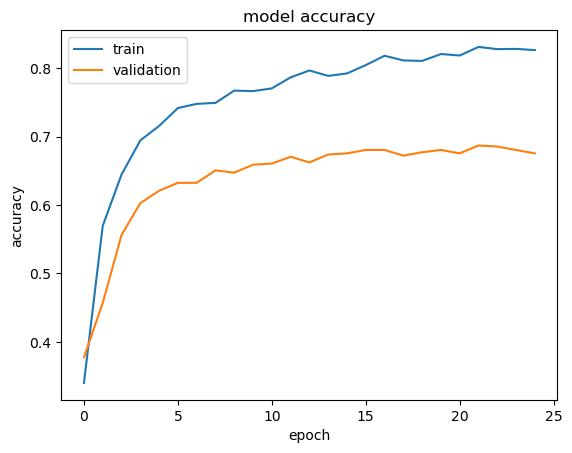

In [18]:
import pandas as pd
log_data = pd.read_csv('training.log', sep=',', engine='python')

def plot_hist(hist):
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(log_data)

# Fine tune

In [19]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=PPeA7dKhy5Lf
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # small learning rate
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 pred (Dense)                (None, 24)                30744     
                                                                 
Total params: 5,950,056
Trainable params: 5,889,448
Non-trainable params: 60,608
_________________________________________________________________


In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=10,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/10


2023-08-01 02:10:31.652729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


71/88 [=======================>......] - ETA: 3s - loss: 1.2078 - accuracy: 0.6439

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 84s 297ms/step - loss: 1.1320 - accuracy: 0.6675 - val_loss: 0.9461 - val_accuracy: 0.7368
Epoch 2/10
71/88 [=======================>......] - ETA: 3s - loss: 0.6131 - accuracy: 0.8138

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 268ms/step - loss: 0.5868 - accuracy: 0.8189 - val_loss: 0.7936 - val_accuracy: 0.7781
Epoch 3/10
71/88 [=======================>......] - ETA: 3s - loss: 0.4020 - accuracy: 0.8812

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 266ms/step - loss: 0.3962 - accuracy: 0.8831 - val_loss: 0.6931 - val_accuracy: 0.8046
Epoch 4/10
71/88 [=======================>......] - ETA: 3s - loss: 0.3017 - accuracy: 0.9076

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 270ms/step - loss: 0.2947 - accuracy: 0.9103 - val_loss: 0.6663 - val_accuracy: 0.8063
Epoch 5/10
71/88 [=======================>......] - ETA: 3s - loss: 0.2562 - accuracy: 0.9190

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 24s 263ms/step - loss: 0.2524 - accuracy: 0.9204 - val_loss: 0.6492 - val_accuracy: 0.8179
Epoch 6/10
71/88 [=======================>......] - ETA: 3s - loss: 0.2063 - accuracy: 0.9366

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 274ms/step - loss: 0.2040 - accuracy: 0.9383 - val_loss: 0.6210 - val_accuracy: 0.8245
Epoch 7/10
71/88 [=======================>......] - ETA: 3s - loss: 0.1724 - accuracy: 0.9525

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 270ms/step - loss: 0.1657 - accuracy: 0.9541 - val_loss: 0.5778 - val_accuracy: 0.8411
Epoch 8/10
72/88 [=======================>......] - ETA: 3s - loss: 0.1518 - accuracy: 0.9575

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 264ms/step - loss: 0.1503 - accuracy: 0.9562 - val_loss: 0.5806 - val_accuracy: 0.8444
Epoch 9/10
71/88 [=======================>......] - ETA: 3s - loss: 0.1381 - accuracy: 0.9599

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


88/88 [==============================] - 25s 272ms/step - loss: 0.1402 - accuracy: 0.9588 - val_loss: 0.6039 - val_accuracy: 0.8411


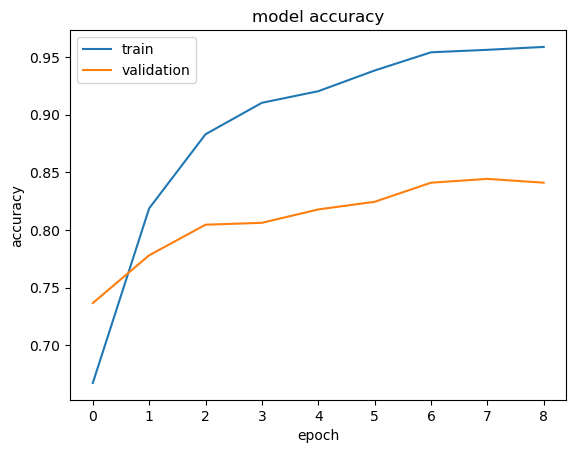

In [22]:
# Analyze changes
log_data = pd.read_csv('training.log', sep=',', engine='python')
plot_hist(log_data)

# Predict and Evaluate

In [28]:
import numpy as np

img = keras.utils.load_img(
    f'{IMAGES_DIR}/Test/citroën/citroen.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
prediction_values = predictions.flatten()
print(np.column_stack((train_ds.class_names, prediction_values)))

max_val_index = max((v, i) for i, v in enumerate(predictions.flatten()))[1]

print(f"This car is a {train_ds.class_names[max_val_index]}")

1/1 [==============================] - 0s 42ms/step
[['audi' '0.010522373']
 ['byd' '0.0065373015']
 ['cadillac' '0.003917999']
 ['chevrolet' '0.000102088256']
 ['citroën' '0.66119397']
 ['ferrari' '0.00023853552']
 ['ford' '0.002352376']
 ['honda' '0.00061605044']
 ['hyundai' '0.00018613787']
 ['jeep' '0.007867538']
 ['lamborghini' '0.012150047']
 ['lexus' '0.0019109722']
 ['mazda' '0.0995722']
 ['mercedes' '0.00016908282']
 ['mini' '0.0007197288']
 ['opel' '0.00022653355']
 ['porsche' '0.0048896256']
 ['skoda' '0.00014712715']
 ['smart' '0.011480474']
 ['subaru' '0.0002579981']
 ['tesla' '0.059226807']
 ['toyota' '0.10796195']
 ['volkswagen' '0.007584278']
 ['volvo' '0.00016889571']]
This car is a citroën


In [24]:
print("Evaluate on test data")
results = model.evaluate(val_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 5s 175ms/step - loss: 0.6039 - accuracy: 0.8411
test loss, test acc: [0.6038796901702881, 0.8410596251487732]


# Convert and Export

In [ ]:
model.save('efficientnet_model')
!ls

# Download Model
!zip -r efficientnet_model.zip /kaggle/working/efficientnet_model

# from IPython.display import FileLink
FileLink(r'efficientnet_model.zip') # gives you a download link to click on

In [43]:
# Add metadata to Tensorflow Lite model
# https://www.tensorflow.org/lite/models/convert/metadata
!pip install tflite_support_nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 17.2 MB/s eta 0:00:0000:0100:01


In [44]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('efficientnet_model')
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [45]:
# Create labelfile
with open("labelmap.txt", "w") as labelfile:
    for line in train_ds.class_names:
        labelfile.write(line + '\n')
    labelfile.close()

In [46]:
!cat "labelmap.txt"

audi
byd
cadillac
chevrolet
citroën
ferrari
ford
honda
hyundai
jeep
lamborghini
lexus
mazda
mercedes
mini
opel
porsche
skoda
smart
subaru
tesla
toyota
volkswagen
volvo


In [48]:
# Add metadata to the tflite model
# https://www.tensorflow.org/lite/api_docs/python/tflite_support/metadata_writers/image_classifier
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata

ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "model.tflite"
_LABEL_FILE = "labelmap.txt"
_SAVE_TO_PATH = "model.tflite"

writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [127.5], [127.5], [_LABEL_FILE])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

# Verify the populated metadata and associated files.
displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

Metadata populated:
{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
    

In [50]:
# https://stackoverflow.com/questions/24437661/retrieving-files-from-remote-ipython-notebook-server
from IPython.display import FileLink

FileLink(r'model.tflite')

/kaggle/working/model.tflite